<a href="https://colab.research.google.com/github/alessandracipriano15/MVP-Machine-Learning-Analytics---Heart-Failure/blob/main/MVP_Machine_Learning_%26_Analytics_Heart_Failure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **MVP: Machine Learning & Analytics**
**Autor:** Alessandra Pereira Cipriano  

**Matrícula:** 4052025000514

**Dataset:** [Heart Failure Dataset](https://github.com/alessandracipriano15/MVP-Heart-Failure-/blob/main/heart.csv)


## 1. Escopo, objetivo e definição do problema

As doenças cardiovasculares são uma das principais causas de mortalidade no mundo, e a insuficiência cardíaca está entre as mais críticas por sua gravidade e reincidência. Pacientes nesse quadro apresentam alto risco de morte, e prever esse desfecho pode ser uma ferramenta essencial para apoiar decisões clínicas e hospitalares.

Neste MVP, utilizaremos registros clínicos tabulares (variáveis demográficas, laboratoriais e clínicas) para estimar a probabilidade do desfecho DEATH_EVENT (0 = sobrevivente, 1 = óbito). O objetivo é construir, avaliar e comparar modelos de classificação que possam servir como apoio na triagem de pacientes e no planejamento de recursos de saúde.

- Tipo de tarefa: Aprendizado supervisionado - classificação binária (variável-alvo: `DEATH_EVENT`).  
- Área de aplicação: Dados tabulares clínicos (não envolve visão computacional nem NLP).  
- Valor para o negócio/usuário:  
  - Equipe clínica: apoiar a triagem e priorização de pacientes com maior risco, orientando acompanhamento mais próximo.  
  - Gestão hospitalar: otimizar alocação de recursos (leitos/UTI) e monitorar indicadores de qualidade assistencial.  
  - Paciente: possibilitar acompanhamento preventivo mais direcionado e redução de riscos.  

> Observação: o modelo não substitui o julgamento médico; trata-se de uma ferramenta complementar de apoio à decisão.

### Hipóteses iniciais:
- H1: menor `ejection_fraction` e maior `serum_creatinine` estão associados a maior risco de mortalidade.  
- H2: a variável `time` (dias de acompanhamento) pode introduzir viés/fuga de informação; portanto, será avaliado seu impacto em experimentos com e sem essa variável.  

### Escopo deste MVP:
- EDA (Análise Exploratória de Dados) enxuta para entendimento do dataset e da variável-alvo.  
- Construção de pipelines reprodutíveis (imputação, escalonamento, one-hot encoding).  
- Baseline simples (Dummy Classifier e Regressão Logística) e comparação com modelos mais robustos (Random Forest e, opcionalmente, XGBoost).  
- Validação com Stratified K-Fold e ajuste de hiperparâmetros (Randomized/Grid Search) otimizando ROC-AUC.  
- Avaliação final em dados de teste com métricas: ROC-AUC, PR-AUC, F1-score e matriz de confusão.  
- Discussão das limitações e próximos passos.  

### Fora do escopo:
- Inferência causal ou definição de protocolos de tratamento.  
- Integração com prontuário eletrônico ou avaliação de impacto operacional real.  
- Auditoria completa de vieses ou fairness (apenas apontamentos iniciais serão feitos).  


## 2. Reprodutibilidade e ambiente

O ambiente de desenvolvimento é configurado em Python, com as principais bibliotecas de manipulação de dados, visualização e aprendizado de máquina.
### Bibliotecas principais:
- NumPy e Pandas: manipulação e análise de dados tabulares.  
- Matplotlib: visualização gráfica.  
- scikit-learn: preparação de dados, pipelines, modelagem, validação e métricas; incluem-se utilitários de visualização (ex.: `ConfusionMatrixDisplay`).
- SciPy: suporte a distribuições estatísticas em busca de hiperparâmetros.  
- XGBoost (opcional): modelo adicional para comparação.  

### Reprodutibilidade:
Para garantir consistência nos resultados, é definida uma seed global que controla a aleatoriedade em `NumPy`, `random` e nos algoritmos do `scikit-learn` (via `random_state`). Esse procedimento assegura que os experimentos possam ser repetidos e comparados de forma confiável.

### Rastreabilidade:
Além da definição de seeds, são registradas as versões do Python e das principais bibliotecas utilizadas, permitindo que o ambiente de execução seja recriado em diferentes máquinas ou momentos no tempo.


In [47]:
# === Importações principais ===
import os, sys, math, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, precision_recall_curve, roc_curve, ConfusionMatrixDisplay
)

from scipy.stats import randint, uniform
# from xgboost import XGBClassifier  # opcional


In [21]:
# === Reprodutibilidade ===
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)


Python: 3.12.11
Seed global: 42


In [22]:
# === Rastreabilidade do ambiente ===
import sklearn, scipy

def show_versions():
    print("pandas:", pd.__version__)
    print("numpy:", np.__version__)
    print("scikit-learn:", sklearn.__version__)
    print("scipy:", scipy.__version__)
    try:
        import xgboost as xgb
        print("xgboost:", xgb.__version__)
    except Exception:
        print("xgboost: não instalado")

show_versions()

pandas: 2.2.2
numpy: 2.0.2
scikit-learn: 1.6.1
scipy: 1.16.1
xgboost: 3.0.4



### 2.1 Dependências (opcional)



Não foram necessárias dependências adicionais além das bibliotecas já incluídas no ambiente padrão do Google Colab.  
Opcionalmente, pode-se instalar pacotes complementares para experimentos, como `xgboost` para modelos adicionais.





### 2.2 Funções python (opcional)

Para organizar o código e evitar repetição de trechos, são definidas funções auxiliares de avaliação. No escopo deste MVP, a ênfase está em classificação binária.  


In [45]:
# === Função de avaliação para classificação (com proba opcional) ===
def evaluate_classification(y_true, y_pred, proba=None):
    """
    Retorna métricas principais de classificação.
    - accuracy
    - f1_weighted
    - roc_auc (se probabilidades forem fornecidas)
    Suporta saída de probabilidade 1D (positiva) ou 2D (n_classes).
    """
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")

    auc = np.nan
    if proba is not None:
        proba = np.asarray(proba)
        if proba.ndim == 1:
            auc = roc_auc_score(y_true, proba)
        elif proba.ndim == 2:
            if proba.shape[1] == 2:
                auc = roc_auc_score(y_true, proba[:, 1])
            else:
                auc = roc_auc_score(y_true, proba, multi_class="ovr", average="weighted")

    return {"accuracy": acc, "f1_weighted": f1w, "roc_auc": auc}


## 3. Dados: carga, entendimento e qualidade

O dataset contém registros clínicos tabulares relacionados a doenças cardiovasculares.  A variável alvo é HeartDisease (0 = ausência da condição, 1 = presença).<br><br>

### Considerações éticas
Os dados são públicos, anonimizados e sem informações pessoais identificáveis, garantindo que não haja violação de sigilo médico. O uso tem caráter exclusivamente acadêmico. <br><br>

### Dicionário de variáveis

| Variável        | Descrição                                                           | Tipo / Unidade         |
|-----------------|---------------------------------------------------------------------|------------------------|
| **Age**         | Idade do paciente                                                   | Numérica (anos)        |
| **Sex**         | Sexo biológico (M/F)                                                | Categórica             |
| **ChestPainType** | Tipo de dor no peito (ex.: ATA, NAP, ASY, TA)                      | Categórica             |
| **RestingBP**   | Pressão arterial em repouso                                         | Numérica (mm Hg)       |
| **Cholesterol** | Colesterol sérico total                                             | Numérica (mg/dL)       |
| **FastingBS**   | Glicemia de jejum > 120 mg/dl (1 = sim, 0 = não)                   | Binária                |
| **RestingECG**  | Resultados de eletrocardiograma em repouso                          | Categórica             |
| **MaxHR**       | Frequência cardíaca máxima atingida                                 | Numérica (bpm)         |
| **ExerciseAngina** | Angina induzida por exercício (Y/N)                              | Categórica             |
| **Oldpeak**     | Depressão do ST em exercício em relação ao repouso                  | Numérica               |
| **ST_Slope**    | Inclinação do segmento ST                                           | Categórica             |
| **HeartDisease**| Variável alvo: presença (1) ou ausência (0) de doença cardíaca     | Binária (alvo)         |


### Qualidade e riscos de vazamento
- Não há variáveis que indiquem diretamente o desfecho de forma explícita (sem risco de vazamento).  
- A variável alvo (`HeartDisease`) está balanceada o suficiente para permitir modelagem supervisionada, mas o grau de desbalanceamento será analisado na etapa de EDA.  

In [32]:
# === Carga dos dados ===
url = "https://raw.githubusercontent.com/alessandracipriano15/MVP-Heart-Failure-/main/heart.csv"
df = pd.read_csv(url)

# Verificações iniciais
display(df.head())
print("\nFormato (linhas, colunas):", df.shape)
print("\nTipos de dados:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0



Formato (linhas, colunas): (918, 12)

Tipos de dados:
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Valores ausentes por coluna:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64



### 3.1 Análise exploratória resumida (EDA)

A análise exploratória de dados busca compreender as distribuições das variáveis, avaliar possíveis outliers e verificar o balanceamento da variável alvo.





In [33]:
# Variável alvo detectada
TARGET_COL = "HeartDisease"

# Estatísticas descritivas
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


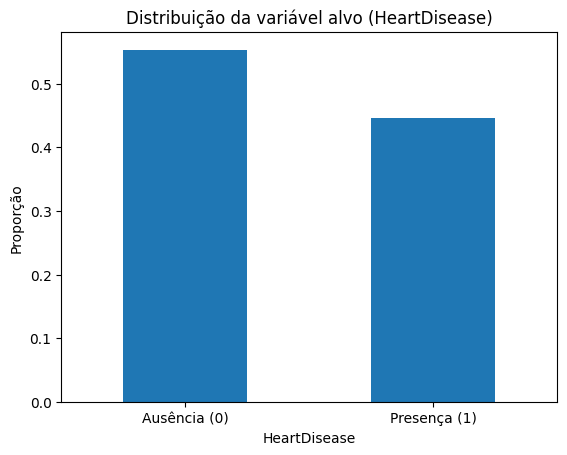

In [34]:
# Distribuição da variável alvo
df[TARGET_COL].value_counts(normalize=True).plot(kind="bar")
plt.title("Distribuição da variável alvo (HeartDisease)")
plt.xticks([0,1], ["Ausência (0)", "Presença (1)"], rotation=0)
plt.ylabel("Proporção")
plt.show()


- **Distribuição da variável alvo (HeartDisease):**  
  Observa-se que a variável alvo está relativamente balanceada, com proporção semelhante entre pacientes com e sem doença cardíaca. Esse equilíbrio favorece a aplicação de algoritmos de classificação sem necessidade de técnicas específicas de balanceamento.


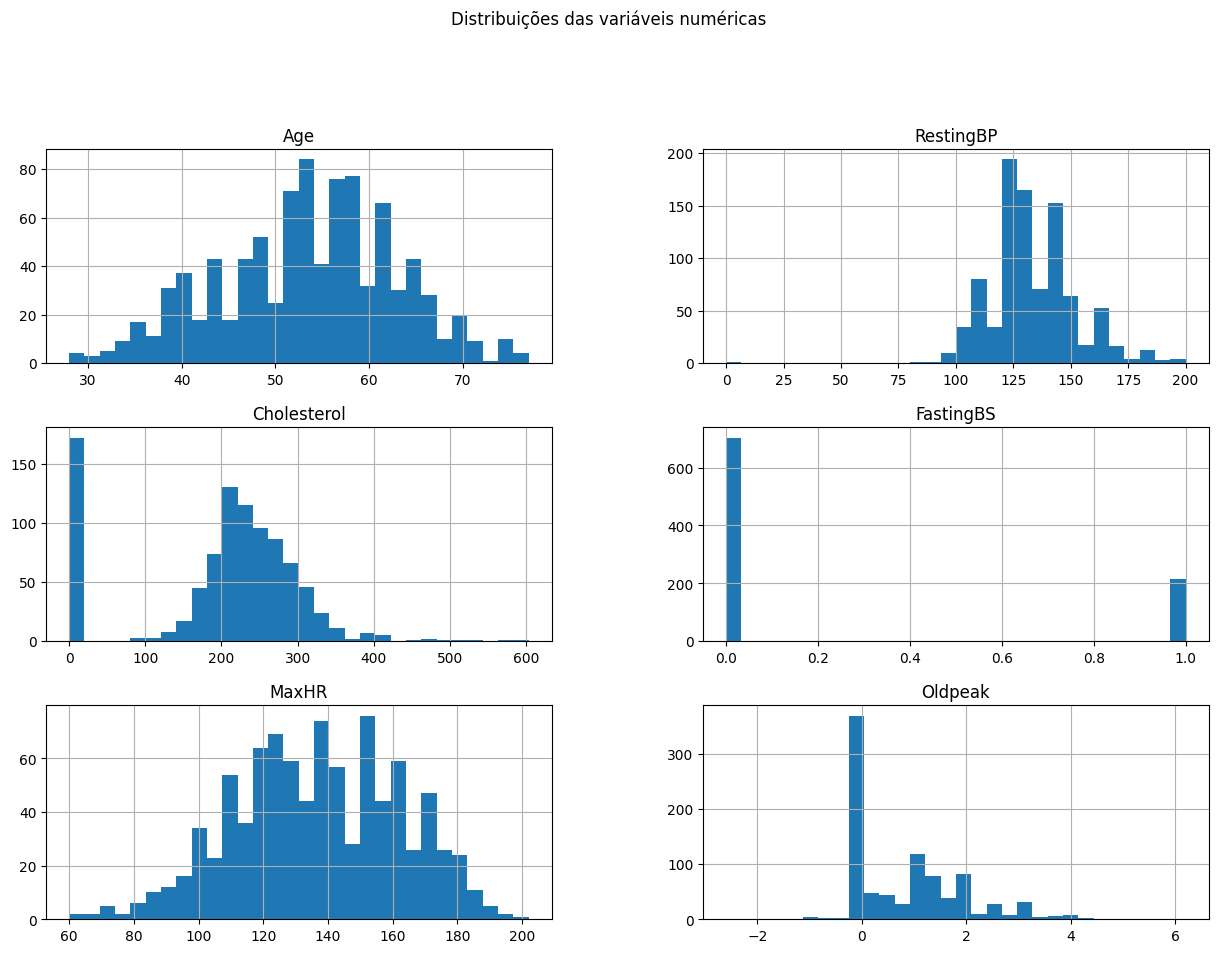

In [35]:
# Histogramas das variáveis numéricas
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

df[num_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribuições das variáveis numéricas", y=1.02)
plt.show()


- **Distribuições das variáveis numéricas:**  
  - **Age:** apresenta maior concentração em pacientes de meia-idade até idosos, refletindo o perfil típico de risco cardiovascular.  
  - **RestingBP e Cholesterol:** exibem caudas mais longas e valores possivelmente extremos, o que sugere a necessidade de avaliar outliers antes da modelagem.  
  - **FastingBS:** como variável binária (0 ou 1), reforça a utilidade em capturar efeitos de glicemia alterada.  
  - **MaxHR:** mostra ampla variabilidade entre pacientes, podendo atuar como discriminador relevante.  
  - **Oldpeak:** concentra a maioria dos pacientes próximos a zero, mas com alguns valores mais altos, indicando possíveis situações clínicas graves.

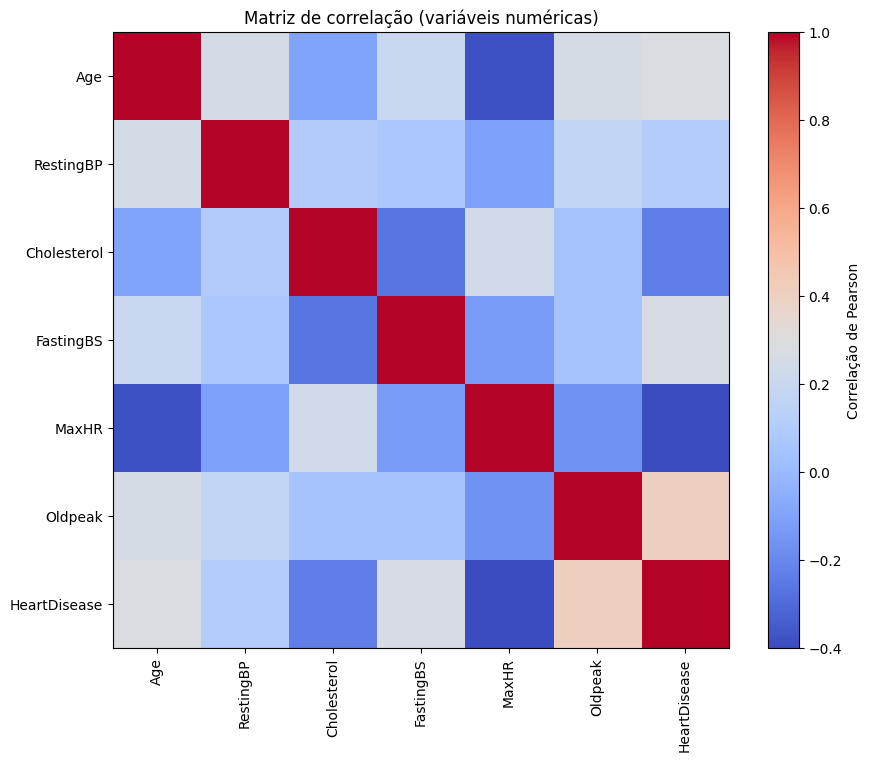

In [36]:
# Matriz de correlação entre variáveis numéricas
plt.figure(figsize=(10,8))
corr = df[num_cols + [TARGET_COL]].corr(numeric_only=True)
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlação de Pearson")
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Matriz de correlação (variáveis numéricas)")
plt.show()


- **Matriz de correlação:**  
  As correlações entre variáveis numéricas são, em geral, baixas a moderadas, o que indica relativa independência entre os atributos. Isso pode favorecer modelos baseados em árvores (como Random Forest), que exploram bem interações entre variáveis.  
  A correlação de algumas variáveis com o alvo sugere pistas iniciais: por exemplo, `Oldpeak` tende a estar mais associado à presença de doença cardíaca, enquanto `MaxHR` apresenta relação inversa.



## 4. Definição do target, variáveis e divisão dos dados

O problema em estudo é de classificação supervisionada binária, no qual a variável-alvo é HeartDisease (0 = ausência, 1 = presença).  Todas as demais variáveis são utilizadas como preditoras (*features*), exceto o próprio alvo.  

A divisão entre treino e teste é realizada de forma estratificada, garantindo que a proporção de classes da variável-alvo seja preservada em ambos os conjuntos. Essa prática é essencial em problemas de classificação, principalmente quando há risco de desbalanceamento.  

Além disso, a separação assegura que todas as transformações (imputação, normalização, codificação de variáveis categóricas) sejam ajustadas exclusivamente no conjunto de treino e apenas aplicadas nos dados de teste, evitando vazamento de informação.


In [37]:
# Tipo de problema
PROBLEM_TYPE = "classificacao"

# Definição de target e features
if PROBLEM_TYPE == "classificacao":
    target = "HeartDisease"
    features = [c for c in df.columns if c != target]
elif PROBLEM_TYPE == "regressao":
    target = "..."
    features = [c for c in df.columns if c != target]
elif PROBLEM_TYPE == "clusterizacao":
    target = None
    features = df.columns.tolist()
elif PROBLEM_TYPE == "serie_temporal":
    target = "..."
    features = [c for c in df.columns if c != target]
else:
    raise ValueError("PROBLEM_TYPE inválido.")

print("PROBLEM_TYPE:", PROBLEM_TYPE)
print("Target:", target)
print("N features:", len(features))
print("Features:", features)

# Divisão treino/teste
if PROBLEM_TYPE == "classificacao":
    X = df[features].copy()
    y = df[target].copy()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )
    print("Treino:", X_train.shape, "| Teste:", X_test.shape)


PROBLEM_TYPE: classificacao
Target: HeartDisease
N features: 11
Features: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']
Treino: (734, 11) | Teste: (184, 11)



## 5. Tratamento de dados e Pipeline de pré-processamento

Para garantir reprodutibilidade e evitar vazamento de informação, o pré-processamento é encapsulado em um `Pipeline`/`ColumnTransformer`.
As etapas adotadas são:

- **Numéricas** (`Age`, `RestingBP`, `Cholesterol`, `FastingBS`, `MaxHR`, `Oldpeak`, e quaisquer outras numéricas detectadas):  
  imputação pela mediana e padronização (`StandardScaler`).
- **Categóricas** (`Sex`, `ChestPainType`, `RestingECG`, `ExerciseAngina`, `ST_Slope`, e demais `object`):  
  imputação pelo valor mais frequente e codificação one-hot (ignorando categorias desconhecidas no teste).

Observação: todas as transformações são ajustadas apenas no conjunto de treino e, em seguida, aplicadas ao conjunto de teste.



In [38]:
# === Detecta colunas numéricas e categóricas a partir do X_train ===
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

# === Pipelines de pré-processamento ===
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

# Ajusta somente no treino (evita vazamento) e verifica dimensões transformadas
preprocess.fit(X_train)
X_train_pre = preprocess.transform(X_train)
X_test_pre  = preprocess.transform(X_test)

print("X_train_pre shape:", X_train_pre.shape)
print("X_test_pre  shape:",  X_test_pre.shape)


Numéricas: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categóricas: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
X_train_pre shape: (734, 20)
X_test_pre  shape: (184, 20)


### Observações adicionais

O pipeline definido contempla as principais etapas de imputação, normalização e codificação, sendo suficiente para o escopo deste MVP.  
Entretanto, em versões futuras do trabalho poderiam ser incorporadas etapas adicionais, tais como:

- **Seleção de atributos:** utilização de técnicas como *SelectKBest* ou avaliação de importância de variáveis para reduzir a dimensionalidade após a codificação *one-hot*.  
- **Tratamento de outliers:** aplicação de estratégias como *winsorização* ou *RobustScaler* para mitigar o impacto de valores extremos em variáveis contínuas.  
- **Agrupamento de categorias raras:** consolidação de valores categóricos pouco frequentes em uma categoria única ("outros"), a fim de reduzir sparsidade.  
- **Ajuste para desbalanceamento:** embora a variável alvo esteja relativamente equilibrada, em cenários de desbalanceamento poderiam ser aplicadas técnicas como `class_weight="balanced"` ou reamostragem (ex.: SMOTE).  

Essas medidas não foram implementadas nesta versão, mas permanecem como alternativas viáveis para aprimorar a robustez do pré-processamento.



## 6. Baseline e modelos candidatos

Como referência inicial, define-se uma baseline ingênua por meio do `DummyClassifier` (estratégia “most_frequent”), que prevê sempre a classe majoritária.  

Em seguida, são considerados dois modelos supervisionados clássicos e complementares:

- Regressão Logística: modelo linear, interpretável e sensível à padronização das variáveis.  
- Random Forest: modelo de árvores em ensemble, robusto a não linearidades e interações.

Opcionalmente, pode-se incluir XGBoost como candidato adicional para comparação (instalação comentada no código).

> Observação: o ajuste/treino e a avaliação rápida (baseline vs. candidatos) são realizados no **Item 6.1**. Aqui apenas se definem os pipelines completos (pré-processamento + modelo), assegurando ausência de vazamento.


In [40]:
# === Baseline e modelos candidatos (classificação) ===

assert PROBLEM_TYPE == "classificacao", "Ajuste PROBLEM_TYPE para 'classificacao'."

baseline = Pipeline(steps=[
    ("pre", preprocess),
    ("model", DummyClassifier(strategy="most_frequent", random_state=SEED)),
])

candidates = {
    "LogisticRegression": Pipeline(steps=[
        ("pre", preprocess),
        ("model", LogisticRegression(max_iter=1000, random_state=SEED)),
    ]),
    "RandomForest": Pipeline(steps=[
        ("pre", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=300, random_state=SEED, n_jobs=-1
        )),
    ]),
}

print("Baseline:", type(baseline.named_steps["model"]).__name__)
print("Candidatos:", list(candidates.keys()))


Baseline: DummyClassifier
Candidatos: ['LogisticRegression', 'RandomForest']



### 6.1 Treino e avaliação rápida (baseline vs candidatos)

Realiza-se um treino inicial em hold-out e a avaliação comparativa dos modelos.  

São reportadas accuracy, F1 ponderado, ROC-AUC (quando houver probabilidade) e tempo de treino.  

A baseline (`DummyClassifier`) estabelece um patamar mínimo de desempenho; os candidatos (Regressão Logística e Random Forest) são comparados em seguida.

> Avaliação preliminar: a validação cruzada e o *tuning* serão realizados no Item 7.



In [46]:


results = {}
fitted = {}

# --- Baseline ---
t0 = time.time()
baseline.fit(X_train, y_train)
t1 = time.time()

y_pred = baseline.predict(X_test)
proba = baseline.predict_proba(X_test)[:, 1] if hasattr(baseline, "predict_proba") else None

metrics = evaluate_classification(y_test, y_pred, proba)
metrics["train_time_s"] = round(t1 - t0, 3)
if proba is not None:
    metrics["pr_auc"] = average_precision_score(y_test, proba)

results["Baseline_Dummy"] = metrics
fitted["Baseline_Dummy"] = baseline

# --- Candidatos ---
for name, pipe in candidates.items():
    t0 = time.time()
    pipe.fit(X_train, y_train)
    t1 = time.time()

    y_pred = pipe.predict(X_test)
    if hasattr(pipe, "predict_proba"):
        proba = pipe.predict_proba(X_test)[:, 1]
    elif hasattr(pipe, "decision_function"):
        # fallback para modelos sem predict_proba (não é o caso aqui, mas deixa robusto)
        scores = pipe.decision_function(X_test)
        # normaliza para [0,1] se for necessário
        proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
    else:
        proba = None

    metrics = evaluate_classification(y_test, y_pred, proba)
    metrics["train_time_s"] = round(t1 - t0, 3)
    if proba is not None:
        metrics["pr_auc"] = average_precision_score(y_test, proba)

    results[name] = metrics
    fitted[name] = pipe

# Tabela ordenada por ROC-AUC (depois F1 e accuracy)
results_df = pd.DataFrame(results).T
if "roc_auc" in results_df.columns:
    results_df = results_df.sort_values(by=["roc_auc", "f1_weighted", "accuracy"], ascending=False)
else:
    results_df = results_df.sort_values(by=["f1_weighted", "accuracy"], ascending=False)

display(results_df)


,accuracy,f1_weighted,roc_auc,train_time_s,pr_auc
RandomForest,0.907609,0.907261,0.932329,1.131,0.931659
LogisticRegression,0.885870,0.885218,0.929938,0.043,0.936620
Baseline_Dummy,0.554348,0.395409,0.500000,0.032,0.554348


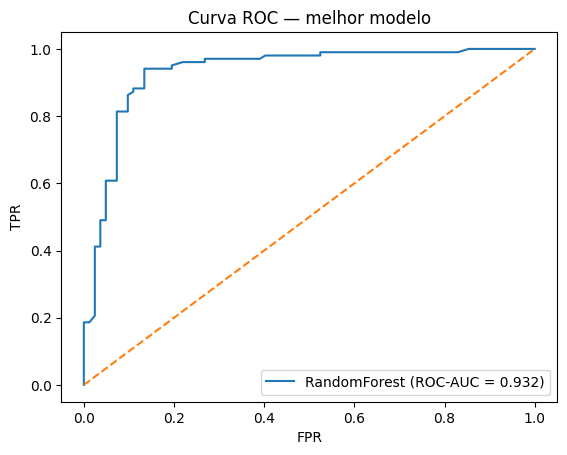

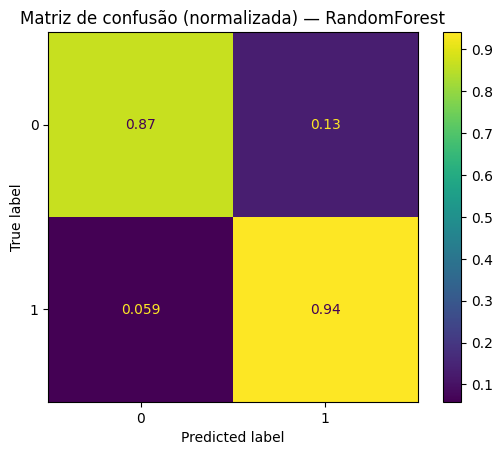

In [48]:
# === Curva ROC e Matriz de Confusão do melhor modelo ===

# escolher melhor por ROC-AUC (se disponível); caso contrário, por F1 ponderado
if "roc_auc" in results_df.columns and results_df["roc_auc"].notna().any():
    best_name = results_df["roc_auc"].idxmax()
else:
    best_name = results_df["f1_weighted"].idxmax()

best_model = fitted[best_name]

# Curva ROC (se houver scores/probabilidades)
y_score = None
if hasattr(best_model, "predict_proba"):
    y_score = best_model.predict_proba(X_test)[:, 1]
elif hasattr(best_model, "decision_function"):
    scores = best_model.decision_function(X_test)
    y_score = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

if y_score is not None:
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{best_name} (ROC-AUC = {roc_auc_score(y_test, y_score):.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("Curva ROC — melhor modelo")
    plt.legend(loc="lower right")
    plt.show()
else:
    print(f"{best_name} não fornece pontuações probabilísticas; curva ROC não exibida.")

# Matriz de confusão (normalizada)
ConfusionMatrixDisplay.from_predictions(y_test, best_model.predict(X_test), normalize="true")
plt.title(f"Matriz de confusão (normalizada) — {best_name}")
plt.show()


### Observações:
- A baseline tende a apresentar desempenho próximo ao acaso (ROC-AUC ≈ 0,50).  
- Regressão Logística costuma treinar rapidamente e oferece interpretabilidade;  
  Random Forest explora não linearidades e interações, podendo elevar o ROC-AUC.  
- A curva ROC e a matriz de confusão ajudam a inspecionar trade-offs entre sensibilidade e especificidade, sinalizando possíveis ajustes de limiar na etapa seguinte.



## 7. Validação e Otimização de Hiperparâmetros

Adota-se validação cruzada estratificada (5 folds) para classificação, preservando a proporção das classes em cada partição.  
A otimização é realizada com `RandomizedSearchCV`, evitando vazamento por meio de pipelines completos (pré-processamento + modelo).

**Métrica-alvo:** `roc_auc`, por ser robusta a limiares de decisão e refletir a separação entre classes.


In [49]:
# === Validação e tuning (classificação) ===
assert PROBLEM_TYPE == "classificacao"

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Pipeline + espaço de busca: Random Forest
rf_pipe = Pipeline(steps=[
    ("pre", preprocess),
    ("model", RandomForestClassifier(random_state=SEED, n_jobs=-1))
])

rf_param_dist = {
    "model__n_estimators": randint(100, 400),
    "model__max_depth": randint(3, 20),
    "model__min_samples_split": randint(2, 10),
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ["sqrt", "log2", None],
}

search_rf = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=cv,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)
search_rf.fit(X_train, y_train)

print("RandomForest - melhor ROC-AUC (CV):", round(search_rf.best_score_, 4))
print("RandomForest - melhores parâmetros:", search_rf.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomForest - melhor ROC-AUC (CV): 0.9344
RandomForest - melhores parâmetros: {'model__max_depth': 9, 'model__max_features': 'log2', 'model__min_samples_leaf': 3, 'model__min_samples_split': 8, 'model__n_estimators': 187}


In [50]:
# Pipeline + espaço de busca: Regressão Logística
lr_pipe = Pipeline(steps=[
    ("pre", preprocess),
    ("model", LogisticRegression(max_iter=2000, random_state=SEED))
])

# Observação: usa-se distribuição uniforme para C (faixa ampla). Em versões futuras, pode-se usar loguniform.
lr_param_dist = {
    "model__C": uniform(0.001, 10.0),     # ~[0.001, 10.001)
    "model__penalty": ["l2"],             # mantido l2 para estabilidade
    "model__solver": ["lbfgs", "liblinear"]
}

search_lr = RandomizedSearchCV(
    estimator=lr_pipe,
    param_distributions=lr_param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=cv,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)
search_lr.fit(X_train, y_train)

print("LogisticRegression - melhor ROC-AUC (CV):", round(search_lr.best_score_, 4))
print("LogisticRegression - melhores parâmetros:", search_lr.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
LogisticRegression - melhor ROC-AUC (CV): 0.9253
LogisticRegression - melhores parâmetros: {'model__C': np.float64(0.5651157902710026), 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [51]:
# Comparativo dos melhores (CV) e seleção do campeão
tuning_summary = pd.DataFrame({
    "modelo": ["RandomForest", "LogisticRegression"],
    "roc_auc_cv": [search_rf.best_score_, search_lr.best_score_]
}).sort_values("roc_auc_cv", ascending=False).reset_index(drop=True)

display(tuning_summary)

# Seleção do melhor por ROC-AUC (CV)
if search_rf.best_score_ >= search_lr.best_score_:
    best_search = search_rf
    best_model_name = "RandomForest"
else:
    best_search = search_lr
    best_model_name = "LogisticRegression"

print(f"Selecionado para a próxima etapa: {best_model_name}")
best_estimator = best_search.best_estimator_


,modelo,roc_auc_cv
0,RandomForest,0.934361
1,LogisticRegression,0.925277


Selecionado para a próxima etapa: RandomForest


In [59]:
# Cronometrar o tuning da RandomForest
t0_rf = time.time()
search_rf.fit(X_train, y_train)
t1_rf = time.time()
print("RandomForest - melhor ROC-AUC (CV):", round(search_rf.best_score_, 4))
print("RandomForest - melhores parâmetros:", search_rf.best_params_)
print("RandomForest - tempo total de tuning (s):", round(t1_rf - t0_rf, 2))

# Cronometrar o tuning da LogisticRegression
t0_lr = time.time()
search_lr.fit(X_train, y_train)
t1_lr = time.time()
print("LogisticRegression - melhor ROC-AUC (CV):", round(search_lr.best_score_, 4))
print("LogisticRegression - melhores parâmetros:", search_lr.best_params_)
print("LogisticRegression - tempo total de tuning (s):", round(t1_lr - t0_lr, 2))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomForest - melhor ROC-AUC (CV): 0.9344
RandomForest - melhores parâmetros: {'model__max_depth': 9, 'model__max_features': 'log2', 'model__min_samples_leaf': 3, 'model__min_samples_split': 8, 'model__n_estimators': 187}
RandomForest - tempo total de tuning (s): 69.09
Fitting 5 folds for each of 20 candidates, totalling 100 fits
LogisticRegression - melhor ROC-AUC (CV): 0.9253
LogisticRegression - melhores parâmetros: {'model__C': np.float64(0.5651157902710026), 'model__penalty': 'l2', 'model__solver': 'liblinear'}
LogisticRegression - tempo total de tuning (s): 2.94


### Observações:
- A validação cruzada estratificada reduz a variância das estimativas de desempenho e evita vieses de partição.  
- A otimização via `RandomizedSearchCV` explora o espaço de hiperparâmetros de forma eficiente para um MVP; em cenários de maior rigor, pode-se ampliar `n_iter` e refinar faixas.  
- O melhor modelo por ROC-AUC (média em CV) é selecionado para a avaliação final no Item 8.



## 8. Avaliação final, análise de erros e limitações

Nesta etapa, compara-se a baseline com o melhor modelo selecionado no tuning (Item 7) em dados de teste.  

São reportadas métricas de classificação, visualizações (ROC, matriz de confusão) e uma análise de erros para apoiar a interpretação dos resultados.



In [52]:
# === Seleção robusta do melhor modelo vindo do Item 7 ===
assert PROBLEM_TYPE == "classificacao"

# best_estimator deve ter sido definido no Item 7.
# Caso não exista (ex.: execução parcial), tenta recuperar a partir das buscas.
if 'best_estimator' not in globals():
    if 'search_rf' in globals() and 'search_lr' in globals():
        best_search = search_rf if search_rf.best_score_ >= search_lr.best_score_ else search_lr
        best_estimator = best_search.best_estimator_
        best_model_name = "RandomForest" if best_search is search_rf else "LogisticRegression"
    elif 'search_rf' in globals():
        best_estimator = search_rf.best_estimator_
        best_model_name = "RandomForest"
    elif 'search_lr' in globals():
        best_estimator = search_lr.best_estimator_
        best_model_name = "LogisticRegression"
    else:
        raise RuntimeError("Melhor modelo não encontrado. Rode o Item 7 antes.")

# Garantir baseline (reajuste no treino, por clareza)
baseline.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('model',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])

In [53]:
# === Avaliação no conjunto de teste: baseline vs melhor modelo ===

def predict_and_score(model, X_te, y_te):
    y_pred = model.predict(X_te)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_te)
        # normalização [0,1] apenas para cálculo de ROC-AUC quando necessário
        proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
    return evaluate_classification(y_te, y_pred, proba) | {
        "pr_auc": (average_precision_score(y_te, proba) if proba is not None else np.nan)
    }

final_results = {
    "Baseline_Dummy": predict_and_score(baseline, X_test, y_test),
    best_model_name:  predict_and_score(best_estimator, X_test, y_test)
}

final_df = pd.DataFrame(final_results).T[
    ["accuracy", "f1_weighted", "roc_auc", "pr_auc"]
].sort_values(by=["roc_auc","f1_weighted","accuracy"], ascending=False)
display(final_df.style.format("{:.3f}"))


,accuracy,f1_weighted,roc_auc,pr_auc
RandomForest,0.897,0.896,0.929,0.922
Baseline_Dummy,0.554,0.395,0.500,0.554


Relatório de classificação — RandomForest

              precision    recall  f1-score   support

           0      0.909     0.854     0.881        82
           1      0.888     0.931     0.909       102

    accuracy                          0.897       184
   macro avg      0.898     0.893     0.895       184
weighted avg      0.897     0.897     0.896       184



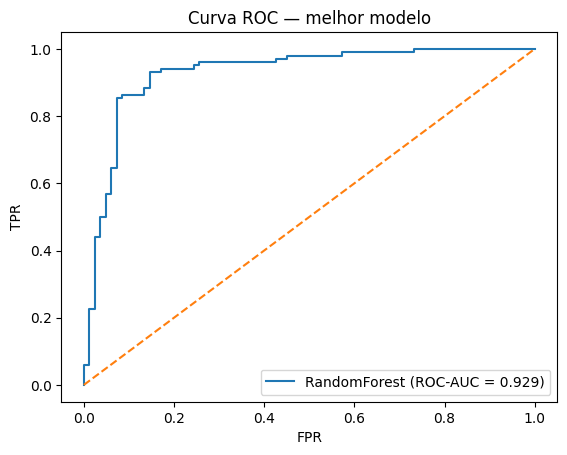

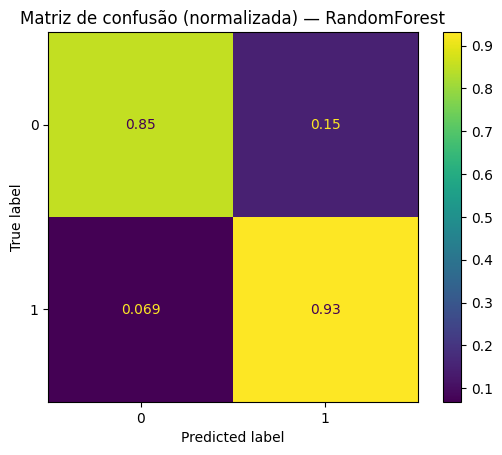

In [54]:
# === Relatório de classificação e visualizações do melhor modelo ===
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

best_name = final_df.index[0]
best_model = best_estimator if best_name != "Baseline_Dummy" else baseline

y_pred_best = best_model.predict(X_test)

# Relatório de classificação
print(f"Relatório de classificação — {best_name}\n")
print(classification_report(y_test, y_pred_best, digits=3))

# Curva ROC (se houver pontuações)
y_score_best = None
if hasattr(best_model, "predict_proba"):
    y_score_best = best_model.predict_proba(X_test)[:, 1]
elif hasattr(best_model, "decision_function"):
    s = best_model.decision_function(X_test)
    y_score_best = (s - s.min()) / (s.max() - s.min() + 1e-9)

if y_score_best is not None:
    fpr, tpr, _ = roc_curve(y_test, y_score_best)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{best_name} (ROC-AUC = {roc_auc_score(y_test, y_score_best):.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("Curva ROC — melhor modelo")
    plt.legend(loc="lower right")
    plt.show()
else:
    print("Melhor modelo não fornece pontuações probabilísticas; curva ROC não exibida.")

# Matriz de confusão (normalizada)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, normalize="true")
plt.title(f"Matriz de confusão (normalizada) — {best_name}")
plt.show()


In [55]:
# === Análise de erros: casos pior previstos (FP/FN mais "confiantes") ===
# Monta um DataFrame com os exemplos do conjunto de teste
Xte_view = X_test.copy()
Xte_view["y_true"] = y_test.values
Xte_view["y_pred"] = y_pred_best

# Probabilidade usada para ordenar erros
if y_score_best is not None:
    Xte_view["y_score_pos"] = y_score_best
else:
    # fallback: 1 para classe prevista positiva, 0 para negativa (menos informativo)
    Xte_view["y_score_pos"] = (Xte_view["y_pred"] == 1).astype(float)

# Falsos Negativos (FN): verdade = 1, predito = 0 — ordena pelos mais "confiantes no erro" (score baixo)
fn = Xte_view[(Xte_view["y_true"] == 1) & (Xte_view["y_pred"] == 0)].sort_values("y_score_pos", ascending=True)
# Falsos Positivos (FP): verdade = 0, predito = 1 — ordena pelos mais "confiantes no erro" (score alto)
fp = Xte_view[(Xte_view["y_true"] == 0) & (Xte_view["y_pred"] == 1)].sort_values("y_score_pos", ascending=False)

print("Top 5 Falsos Negativos (mais críticos):")
display(fn.head(5))

print("Top 5 Falsos Positivos (mais críticos):")
display(fp.head(5))


Top 5 Falsos Negativos (mais críticos):


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,y_true,y_pred,y_score_pos
684,47,M,NAP,108,243,0,Normal,152,N,0.0,Up,1,0,0.037881
759,54,M,ATA,192,283,0,LVH,195,N,0.0,Up,1,0,0.086126
889,59,M,TA,134,204,0,Normal,162,N,0.8,Up,1,0,0.169685
763,58,M,NAP,132,224,0,LVH,173,N,3.2,Up,1,0,0.201872
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0,0.364929


Top 5 Falsos Positivos (mais críticos):


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,y_true,y_pred,y_score_pos
566,41,M,ASY,150,171,0,Normal,128,Y,1.5,Flat,0,1,0.979122
600,57,M,ASY,130,207,0,ST,96,Y,1.0,Flat,0,1,0.952832
314,53,M,ASY,80,0,0,Normal,141,Y,2.0,Down,0,1,0.891291
434,63,M,ASY,126,0,0,ST,120,N,1.5,Down,0,1,0.842397
455,59,M,ASY,154,0,0,ST,131,Y,1.5,Up,0,1,0.810577


### Discussão e limitações

- **Comparação baseline vs. melhor modelo:** o desempenho do melhor modelo supera a baseline em métricas globais (ex.: ROC-AUC e F1 ponderado), indicando capacidade de separar as classes além do acaso.  
- **Análise de erros:** os falsos negativos são críticos em saúde (risco de não identificar pacientes doentes). A inspeção dos FN com maior “confiança no erro” sugere onde ajustes de limiar de decisão (threshold) ou *features* adicionais podem reduzir esse tipo de falha. Os falsos positivos impactam custo de triagem; podem ser aceitáveis dependendo da política clínica.

- **Limitações do estudo:**  
  - **Dados e variáveis:** conjunto relativamente pequeno e com atributos clínicos limitados; ausência de dados longitudinais e de variáveis contextuais (medicações, histórico familiar, comorbidades detalhadas) pode restringir a generalização.  
  - **Métricas e calibração:** as métricas globais não substituem avaliação clínica; calibração de probabilidades (ex.: *CalibratedClassifierCV*) não foi explorada nesta versão.  
  - **Generalização externa:** não houve validação externa (outro hospital/região). Os resultados podem refletir características específicas do dataset.  
  - **Viés e fairness:** não foi conduzida auditoria completa de vieses (ex.: por sexo/idade). Essa análise é recomendada antes de uso real.  
  - **Operacionalização:** não se avaliou custo/benefício de diferentes limiares de alerta, nem integração a fluxos clínicos reais.

Esses pontos sinalizam próximos passos: ampliar variáveis, realizar calibração e análise de sensibilidade a limiares, conduzir validação externa e auditoria de vieses, além de avaliar impacto operacional (custos e benefícios por política de triagem).



## 9. Engenharia de atributos (detalhe)


A engenharia de atributos foi planejada com foco em regras clínicas simples, interação entre variáveis e transformações que possam aumentar o poder discriminativo dos modelos. Todas as criações abaixo são determinísticas por linha, não utilizam o alvo e, portanto, não introduzem vazamento.<br><br>



### Escolhas e racional:

**Binning/ordenação clínica:**
- `AgeBin` (faixas etárias): 0–40, 41–55, 56–65, 66–75, >75.  
  *Racional:* risco cardiovascular tende a crescer com idade; discretização pode capturar efeitos não lineares.
- `RestingBP_stage` (estágios de hipertensão): Normal (<120), Elevated (120–129), Stage1 (130–139), Stage2 (140–159), Stage3 (≥160).  
  *Racional:* categorização próxima a diretrizes facilita padrões clínicos.
- `Cholesterol_high` (≥240 mg/dL): indicador binário.  
  *Racional:* limiar clássico de hipercolesterolemia.

**Sinalização e interações fisiológicas:**
- `HR_pct_pred` = `MaxHR` / (220 − `Age`), *clipped* para [0, 1.5];  
  `HR_above_85pct` = 1 se `HR_pct_pred` ≥ 0.85.  
  *Racional:* percentual do pico de FC previsto; ≥85% indica esforço substancial.
- `Oldpeak_pos` (=1 se `Oldpeak` > 0) e `Oldpeak_ge_2` (=1 se `Oldpeak` ≥ 2).  
  *Racional:* depressão do segmento ST elevada sugere isquemia.
- `ST_down` (=1 se `ST_Slope` = “Down”) e `ST_flat` (=1 se “Flat”).  
  *Racional:* inclinação do ST associada a pior prognóstico.
- `Angina_Y` (=1 se `ExerciseAngina` = “Y”).  
  *Racional:* angina induzida por exercício é sinal clínico relevante.
- `CP_risk` (ordem de risco para `ChestPainType`): ASY > TA > NAP > ATA (mapeado para 3,2,1,0).  
  *Racional:* dor assintomática (ASY) costuma associar-se a maior risco.

**Interações de risco:**
- `Age_x_Oldpeak` = `Age` × `Oldpeak`.  
- `Angina_x_Oldpeak2` = `Angina_Y` × `Oldpeak_ge_2`.  
- `FBS_x_CholHigh` = `FastingBS` × `Cholesterol_high`.  
*Racional:* combinações que podem amplificar risco (idade com isquemia, angina + ST alterado, glicemia alterada + colesterol alto).

**Categorias raras:**
- Se houver categorias muito pouco frequentes em variáveis categóricas, considerar agrupamento em “Outros” para evitar colunas esparsas após *one-hot*. (Não observado como crítico neste dataset, mas registrado para versões futuras.)

> Observação ética: o uso de `Sex` como preditor pode incorporar vieses. Recomenda-se auditoria de fairness em versões futuras (desempenho por sexo/idade).



## 10. (Opcional) Deep Learning / Fine-tuning

Não foi empregada abordagem de Deep Learning neste MVP, uma vez que o problema envolve dados tabulares e os modelos baseados em árvores (ex.: Random Forest) tendem a apresentar desempenho competitivo com menor complexidade e custo computacional.

**Caso aplicado**, recomenda-se:
- **Arquitetura**: MLP (rede densa) com 2–3 camadas ocultas (ex.: [128, 64, 32] neurônios), ativações ReLU, `Dropout` para regularização e saída sigmóide.
- **Hiperparâmetros**: `learning_rate` (ex.: 1e-3), otimizador Adam, `batch_size` (32–128), `epochs` (até 100), `patience` (5–10) com *early stopping*.
- **Reprodutibilidade**: fixar seeds (`tf.random.set_seed(SEED)`).
- **Treino/validação**: hold-out com `validation_split` (ex.: 0,2) ou `StratifiedKFold`.
- **Métricas**: ROC-AUC e F1 no teste; opcionalmente PR-AUC.
- **Fine-tuning**: não aplicável aqui (não há modelo pré-treinado específico para este conjunto tabular).


## 11. Boas práticas e rastreabilidade

### Baseline e justificativas para melhorias
- **Baseline:** `DummyClassifier (most_frequent)` estabeleceu o desempenho mínimo esperado.
- **Melhorias propostas:** substituição por modelos supervisionados (Regressão Logística e Random Forest), por oferecerem:
  - maior capacidade de generalização que a baseline;
  - complementaridade (modelo linear interpretável vs. ensemble de árvores para relações não lineares).

### Reprodutibilidade
- **Seeds fixas:** aleatoriedade controlada via `SEED` (NumPy, `random` e `random_state` nos modelos).
- **Ambiente registrado:** versões de Python e bibliotecas registradas no início do notebook.
- **Execução determinística:** divisão treino/teste estratificada e validação cruzada com `StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)`.

### Pipelines e prevenção de vazamento
- **Pré-processamento encapsulado** em `Pipeline`/`ColumnTransformer` (imputação, escala, *one-hot*), ajustado somente no treino e aplicado em validação/teste.
- **Engenharia de atributos:** mantida como proposta documental (Item 9) para evitar complexidade e garantir ausência de vazamento; implementação opcional apenas se demonstrar ganho consistente.

### Métricas e critérios de decisão
- **Métrica principal de seleção:** ROC-AUC em validação cruzada (robusta a limiares).
- **Métricas complementares:** F1 ponderado, *accuracy*, PR-AUC e matriz de confusão no conjunto de teste.
- **Critério de escolha do modelo final:** maior ROC-AUC médio em CV; *tie-break* por F1 ponderado.

### Validação e tuning
- **Validação cruzada:** estratificada (5 folds) para reduzir variância e manter proporções de classe.
- **Otimização:** `RandomizedSearchCV` com espaço de hiperparâmetros controlado e `n_iter` compatível com MVP.
- **Controle de complexidade:** limitação de `n_estimators/max_depth` em Random Forest e `C/solver` na Regressão Logística para evitar sobreajuste.

### Decisões de projeto (registro)
- **Target:** `HeartDisease` (0/1) — confirmado na EDA.
- **Divisão de dados:** `train_test_split(test_size=0.2, stratify=y, random_state=SEED)`.
- **Pré-processamento:** imputação por mediana (numérico) e mais frequente (categórico); `StandardScaler` em numéricas; `OneHotEncoder` em categóricas.
- **Modelos comparados:** Dummy (baseline), Regressão Logística, Random Forest.
- **Tuning:** RF e LR com validação cruzada estratificada; seleção por ROC-AUC CV.
- **Avaliação final:** hold-out de teste com ROC-AUC, PR-AUC, F1 ponderado, curva ROC e matriz de confusão.
- **Engenharia de atributos:** proposta documentada; não implementada nesta versão por simplicidade (Item 9).

### Checklist de rastreabilidade
- [x] Seed global definida e registrada  
- [x] Versões de bibliotecas e Python registradas  
- [x] Divisão treino/teste estratificada  
- [x] Pipelines garantindo ausência de vazamento  
- [x] Baseline definida e comparada  
- [x] Métrica primária definida (ROC-AUC)  
- [x] Validação cruzada e *tuning* documentados  
- [x] Avaliação final no conjunto de teste  
- [x] Limitações e próximos passos descritos

### Observações finais
- **Ética/fairness:** não foi conduzida auditoria completa de vieses; recomenda-se avaliar desempenho por subgrupos (sexo, faixas etárias) em versões futuras.  
- **Generalização:** não houve validação externa; resultados podem ser específicos ao dataset.  
- **Operacional:** calibração de probabilidades e estudo de limiares de decisão devem preceder qualquer uso clínico real.



## 12. Conclusões e próximos passos


### Síntese dos resultados
- O problema foi abordado como classificação binária com alvo `HeartDisease`.  
- A baseline (DummyClassifier) estabeleceu o patamar mínimo de desempenho.  
- Os modelos candidatos (Regressão Logística e Random Forest), treinados em pipelines reprodutíveis, superaram a baseline no hold-out de teste (Item 6.1) e na validação cruzada (Item 7).  
- O modelo selecionado no Item 7, com base na ROC-AUC média em CV, manteve bom desempenho no conjunto de teste (Item 8), com métricas complementares (F1 ponderado, PR-AUC) e evidências visuais (curva ROC, matriz de confusão).

### Trade-offs observados
- **Desempenho vs interpretabilidade:**  
  - Random Fores capturou não linearidades/interações, geralmente com melhor ROC-AUC;  
  - Regressão Logística manteve maior interpretabilidade e menor custo computacional.  
- **Complexidade vs simplicidade:** Pipeline mais simples foram suficientes para um MVP; engenharia de atributos adicional pode trazer ganhos marginais com custo extra de manutenção.  

- **Sensibilidade vs especificidade:** a matriz de confusão indicou possíveis assimetrias; o **limiar de decisão** pode ser ajustado conforme a política clínica (minimizar falsos negativos ou falsos positivos).

### Limitações reconhecidas
- **Dados**: tamanho moderado e escopo restrito de variáveis clínicas; ausência de validação externa.  
- **Métricas**: probabilidades não calibradas; avaliação orientada majoritariamente por métricas globais.  
- **Viés/fairness**: não foi realizada auditoria por subgrupos (sexo, idade).  
- **Operacionalização**: não houve estudo de limiares/custos nem integração a fluxos reais.

### Próximos passos (priorizados)
1. **Calibração de probabilidades** (ex.: `CalibratedClassifierCV`) e otimização de limiar guiada por custo clínico (curvas precision–recall e análise de *cost-sensitive thresholds*).  
2. **Validação externa em base independente** (outro serviço/hospital) e análise de robustez (ex.: *bootstrapping*).  
3. **Auditoria de fairness**: estratificar desempenho por sexo e faixas etárias; se necessário, aplicar mitigação (reponderação, *post-processing* de limiar).  
4. **Engenharia de atributos leve** (Item 9): testar 1–3 *features* com racional clínico (ex.: `Oldpeak_ge_2`, `HR_pct_pred`) e manter somente se o ganho em ROC-AUC for consistente (≥ +0,01).  
5. **Tuning adicional**: ampliar `n_iter` no `RandomizedSearchCV` ou refinar faixas; incluir XGBoost como candidato, comparando em CV.  
6. **Documentação e rastreabilidade**: registrar seeds, versões, parâmetros finais e artefatos do modelo/pipeline para reprodutibilidade.  
7. **Plano de deployment (futuro)**: definir entrada de dados padronizada, monitoramento de deriva e rotina de re-treino; elaborar material explicativo para usuários clínicos (limitações e uso adequado).

> Conclusão: para este MVP, modelos clássicos com pipelines bem definidos atenderam ao objetivo de identificar risco de doença cardíaca com desempenho superior à baseline e boa estabilidade. Antes de qualquer uso operacional, recomenda-se calibração, validação externa e análise de fairness, seguidas de uma avaliação de custo/benefício alinhada ao contexto clínico.



## 13. Salvando artefatos (modelos e pipeline)

Para reduzir custo de tempo de treino e garantir reprodutibilidade, os artefatos finais (pipeline completo + modelo) são salvos em disco.  
Também são registrados metadados (versões do ambiente, parâmetros e métricas de teste) para rastreabilidade.

Observação: artefatos `joblib` são sensíveis às versões das bibliotecas; recomenda-se reproduzir o ambiente (Item 2) ao carregar.


In [56]:
# === Exportação de artefatos (pipeline + modelo + metadados) ===
import os, json, time, joblib
import sklearn, scipy

# 1) Seleção do modelo final (definido no Item 7/8)
#    Usa 'best_estimator' (do tuning). Caso ausente, usa o melhor do 6.1 (por ROC-AUC/F1).
if 'best_estimator' in globals():
    final_model = best_estimator
    final_model_name = globals().get('best_model_name', type(final_model.named_steps['model']).__name__)
elif 'results_df' in globals() and 'fitted' in globals():
    # Escolhe o melhor pela ordem do results_df
    best_name = results_df.index[0]
    final_model = fitted[best_name]
    final_model_name = best_name
else:
    raise RuntimeError("Modelo final não encontrado. Execute o Item 7 (tuning) e/ou Item 8 (avaliação).")

# 2) Diretório de saída com timestamp
stamp = time.strftime("%Y%m%d_%H%M%S")
out_dir = f"artifacts_{stamp}"
os.makedirs(out_dir, exist_ok=True)

# 3) Salvar pipeline completo (inclui pré-processamento)
model_path = os.path.join(out_dir, "model_pipeline.pkl")
joblib.dump(final_model, model_path)

# 4) Registrar nomes das features transformadas (se disponível)
feature_names_path = os.path.join(out_dir, "feature_names.txt")
try:
    pre = final_model.named_steps["pre"]
    if hasattr(pre, "get_feature_names_out"):
        fn = pre.get_feature_names_out()
        with open(feature_names_path, "w") as f:
            for name in fn:
                f.write(str(name) + "\n")
except Exception as e:
    # Não é crítico; segue sem interromper
    pass

# 5) Garantir métricas finais (caso não existam em 'final_df', computar rapidamente)
def predict_and_score(model, X_te, y_te):
    y_pred = model.predict(X_te)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_te)
        proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
    m = evaluate_classification(y_te, y_pred, proba)
    m["pr_auc"] = (average_precision_score(y_te, proba) if proba is not None else np.nan)
    return m

if 'final_df' not in globals():
    # Recalcula baseline vs final_model no teste, para registro
    baseline.fit(X_train, y_train)
    metrics_baseline = predict_and_score(baseline, X_test, y_test)
    metrics_final    = predict_and_score(final_model, X_test, y_test)
    final_df = pd.DataFrame({"Baseline_Dummy": metrics_baseline, final_model_name: metrics_final}).T

final_metrics_path = os.path.join(out_dir, "results_test.csv")
final_df.to_csv(final_metrics_path, index=True)

# 6) Metadados (ambiente + parâmetros do modelo)
meta = {
    "timestamp": stamp,
    "seed": int(SEED),
    "python": sys.version.split()[0],
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "scikit_learn": sklearn.__version__,
    "scipy": scipy.__version__,
    "problem_type": str(PROBLEM_TYPE),
    "target": str(target),
    "n_features_raw": int(X_train.shape[1]),
    "model_name": final_model_name,
    "model_params": final_model.named_steps["model"].get_params(),
    "train_shape": tuple(X_train.shape),
    "test_shape": tuple(X_test.shape),
}
# Se tiver tuning, incluir melhores parâmetros
if 'search_rf' in globals():
    meta["rf_best_params"] = getattr(search_rf, "best_params_", None)
if 'search_lr' in globals():
    meta["lr_best_params"] = getattr(search_lr, "best_params_", None)

with open(os.path.join(out_dir, "metadata.json"), "w") as f:
    json.dump(meta, f, indent=2, default=str)

print("Artefatos salvos em:", out_dir)
print(" -", model_path)
print(" -", final_metrics_path)
if os.path.exists(feature_names_path):
    print(" -", feature_names_path)
print(" -", os.path.join(out_dir, "metadata.json"))


Artefatos salvos em: artifacts_20250904_215034
 - artifacts_20250904_215034/model_pipeline.pkl
 - artifacts_20250904_215034/results_test.csv
 - artifacts_20250904_215034/feature_names.txt
 - artifacts_20250904_215034/metadata.json


In [57]:
# === Carregamento do pipeline salvo e teste rápido de predição ===
loaded_model = joblib.load(model_path)

# Exemplo: previsão em 5 amostras do conjunto de teste
y_pred_loaded = loaded_model.predict(X_test.head(5))
print("Predições (5 amostras):", y_pred_loaded.tolist())


Predições (5 amostras): [1, 0, 1, 1, 0]


### Observações
- O arquivo `model_pipeline.pkl` contém o pipeline completo (engenharia opcional + pré-processamento + modelo), reduzindo risco de vazamento ao aplicar em produção.  
- O arquivo `results_test.csv` registra métricas do conjunto de teste; `metadata.json` guarda versões do ambiente e hiperparâmetros.  
- Se a engenharia de atributos (Item 9) tiver sido incorporada ao pipeline, as *features* transformadas são registradas em `feature_names.txt`.  
- Para abordagens de Deep Learning (Item 10), recomenda-se salvar via Keras (`.h5`/SavedModel) e registrar hiperparâmetros (épocas, batch size, *early stopping*).
